# Aplicando PCA sobre RandomForest

En este JN, voy a aplicarle un PCA para saber si puedo mejorar mi modelo de alguna forma.

Al final, en la sección de Conclusiones, valoraré si finalmente le aplico a mi modelo PCA o no.

*Cada vez que aplico un PCA vuelvo a importar las librerías y a cargar el datasaset dado que si no lo hago me da error al calcular determinados scores o coeficientes.

Empiezo importando las librerías que voy a utilizar y cargando mi dataset.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas.io

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy import interp

from itertools import cycle

import seaborn as sns

import pickle

In [3]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    return theDataFrame

data = readCsvToDataFrame('data_fourier.csv')

# PCA - 20

Empiezo probando a reducir el número de features de mi modelo a 20, para obtener las diferentes métricas que he obtenido antes, y ver si mejoran sustancialmente mis resultados.

Empiezo escalando las diferentes features que tengo para podemos aplicarle el PCA.

In [4]:
features = ['mfcc', 'scem','scom', 'srom','sbwm', 'tempo', 'rmse', 
            'Fourier1', 'Fourier2', 'Fourier3', 'Fourier4', 'Fourier5', 
            'Fourier6', 'Fourier7', 'Fourier8', 'Fourier9', 'Fourier10',
            'Fourier11', 'Fourier12', 'Fourier13', 'Fourier14', 'Fourier15',
            'Fourier16', 'Fourier17', 'Fourier18', 'Fourier19', 'Fourier20',
            'Fourier21', 'Fourier22', 'Fourier23', 'Fourier24', 'Fourier25',
            'Fourier26', 'Fourier27', 'Fourier28', 'Fourier29', 'Fourier30',
            'Fourier31', 'Fourier32']

x = data.loc[:, features].values
y = data.loc[:,['momento']].values

x = StandardScaler().fit_transform(x)

A continuación le aplico el PCA, reduciendo las features de 39 a 20, y muestro el dataset resultante.

In [5]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1',
                                      'principal component 2',
                                      'principal component 3',
                                      'principal component 4',
                                      'principal component 5',
                                      'principal component 6',
                                      'principal component 7',
                                      'principal component 8',
                                      'principal component 9',
                                      'principal component 10',
                                      'principal component 11',
                                      'principal component 12',
                                      'principal component 13',
                                      'principal component 14',
                                      'principal component 15',
                                      'principal component 16',
                                      'principal component 17',
                                      'principal component 18',
                                      'principal component 19',
                                      'principal component 20'])

principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20
0,-3.360904,-0.975100,-1.054815,-0.385678,-0.764155,1.670289,0.644852,0.227854,0.942620,-0.075754,0.939617,-1.530147,0.986967,-0.301151,0.098625,-0.221323,-0.177318,0.216629,-0.282358,0.136173
1,-1.026358,1.479483,0.076902,0.862367,-0.545420,-0.375335,1.328116,-0.022565,0.098361,1.234505,0.623322,-0.326806,0.661453,-0.645822,-0.221837,-0.280299,-0.463400,0.005236,-0.187494,0.482452
2,2.956737,-3.923936,1.228267,-0.877433,0.766129,-1.248008,0.139148,-1.652299,-0.563518,-0.658161,-1.172418,-0.690175,-0.622107,-0.178167,-0.203372,0.325577,0.667491,-0.764665,1.522598,-0.039721
3,4.548091,1.769833,-1.323475,0.451322,0.720803,0.862265,-0.963634,0.311261,0.172204,1.220620,-0.397146,0.301051,-0.859741,-0.005403,0.230711,-0.478117,0.708306,-0.949496,0.516940,-0.926520
4,-0.471525,-2.539756,0.897380,-0.962164,0.426873,-0.069561,-0.488677,0.016468,0.213359,0.032536,0.618737,0.544154,-0.914838,-0.446622,0.126065,-0.242965,0.196122,0.070157,-0.416034,0.005362


Y ahora, para poder trabajar y concatenar la X y la y de forma correcta y que no me de errores, reseteo los índices de ambos dataframes.

In [6]:
principalDf.reset_index(drop=True, inplace=True)

aux = data[['momento']]
aux.reset_index(drop=True, inplace=True)

finalDf = pd.concat([principalDf, aux], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,momento
0,-3.360904,-0.975100,-1.054815,-0.385678,-0.764155,1.670289,0.644852,0.227854,0.942620,-0.075754,...,-1.530147,0.986967,-0.301151,0.098625,-0.221323,-0.177318,0.216629,-0.282358,0.136173,Timbre
1,-1.026358,1.479483,0.076902,0.862367,-0.545420,-0.375335,1.328116,-0.022565,0.098361,1.234505,...,-0.326806,0.661453,-0.645822,-0.221837,-0.280299,-0.463400,0.005236,-0.187494,0.482452,Cena
2,2.956737,-3.923936,1.228267,-0.877433,0.766129,-1.248008,0.139148,-1.652299,-0.563518,-0.658161,...,-0.690175,-0.622107,-0.178167,-0.203372,0.325577,0.667491,-0.764665,1.522598,-0.039721,Lavadora
3,4.548091,1.769833,-1.323475,0.451322,0.720803,0.862265,-0.963634,0.311261,0.172204,1.220620,...,0.301051,-0.859741,-0.005403,0.230711,-0.478117,0.708306,-0.949496,0.516940,-0.926520,Secador_pelo
4,-0.471525,-2.539756,0.897380,-0.962164,0.426873,-0.069561,-0.488677,0.016468,0.213359,0.032536,...,0.544154,-0.914838,-0.446622,0.126065,-0.242965,0.196122,0.070157,-0.416034,0.005362,Aire_acondicionado


Debido a la reducción de features al aplicar el CA, parte de la totalidad de la variación explicada del modelo original se pierde, por lo que voy a ver cómo se distribuye esta variación entre las 20 features, cuánta variación se explica y cuánta se ha perdido.

In [7]:
print('La variación explicada por cada feature ha sido de {} respectivamente.'.format(pca.explained_variance_ratio_))
print('La variación explicada total de este modelo con respecto al original ha sido del {:.2f}%.'.format(np.sum(pca.explained_variance_ratio_)*100))
print('La variación perdida con respecto al modelo original ha sido del {:.2f}%.'.format(100 - np.sum(pca.explained_variance_ratio_)*100))

La variación explicada por cada feature ha sido de [0.42508945 0.13246001 0.06637617 0.04350658 0.04267793 0.03105387
 0.02702827 0.02502397 0.0234128  0.02142979 0.02016685 0.0194427
 0.01632729 0.01495322 0.01461487 0.01315067 0.01281677 0.01189209
 0.01089021 0.01055975] respectivamente.
La variación explicada total de este modelo con respecto al original ha sido del 98.29%.
La variación perdida con respecto al modelo original ha sido del 1.71%.


Como se puede observar debajo, la correlación entre las diferentes features prácticamente ha desaparecido.

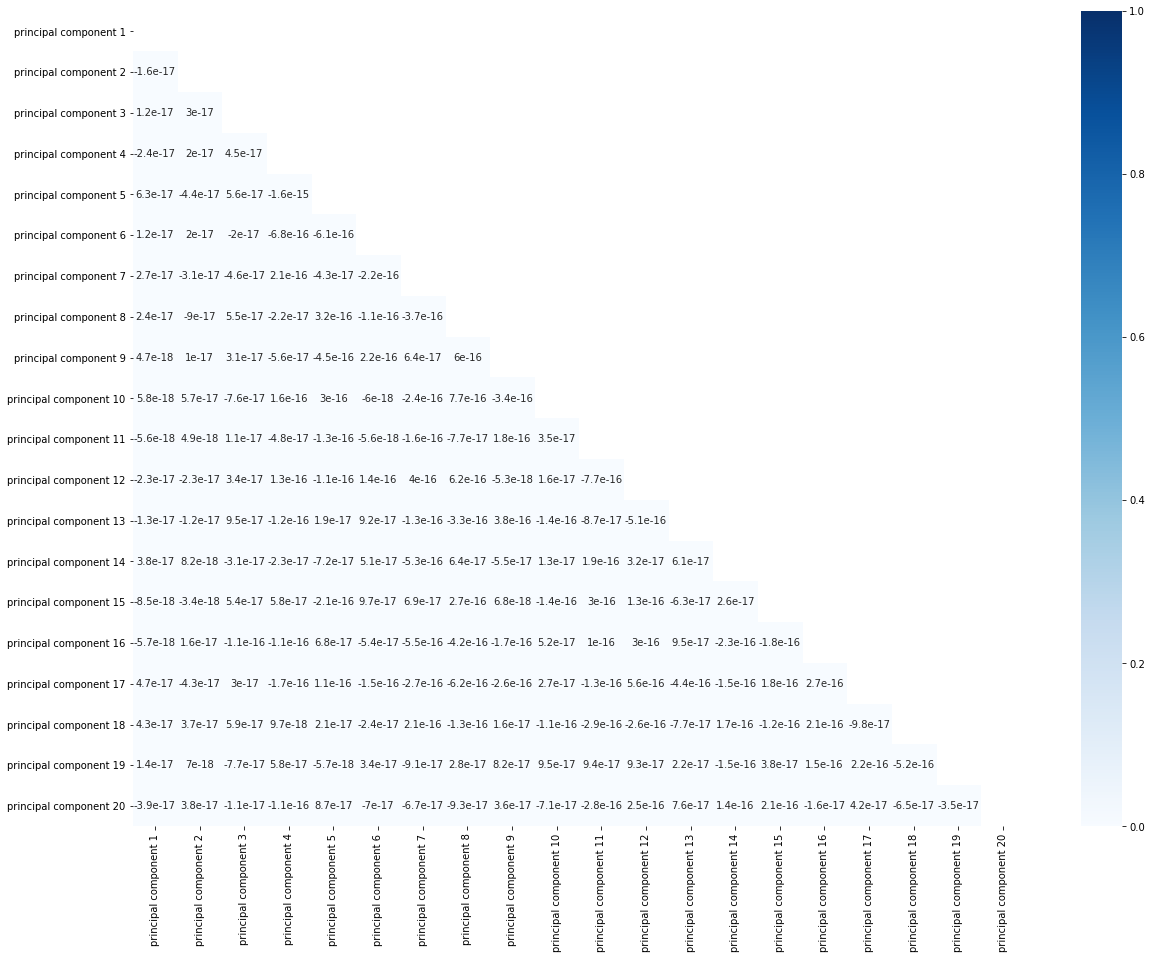

In [8]:
def get_matrix(dataset, classes):
    mask = np.zeros_like(dataset.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20,15))
    ax = sns.heatmap(dataset.corr(), mask=mask, annot=True, cmap="Blues")

#     sns.set(style="ticks")
#     sns.pairplot(dataset, hue=classes)
    
get_matrix(finalDf, 'momento')

Y termino con el mismo análisis que hice con el modelo original.

Es por ello que noy voy a entrar a dar epxlicaciones ni para este modelo ni para el resto de PCA, dado que las voy a dar todas juntas en la sección final de Conclusiones de este JN.

In [10]:
y = pd.get_dummies(data=finalDf.momento)
X = data.loc[:, finalDf.columns != 'momento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [11]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=60))
# scores = cross_val_score(clf, X, y, cv=20)
# print(scores)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [12]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.972396925227114

In [13]:
predictions = clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.00
Aire_acondicionado    0.00
Alarma                0.00
Aspiradora            0.00
Cena                  0.00
Ducha                 0.00
Grifo                 0.00
Lavadora              0.00
Licuadora             0.01
Microondas            0.00
Secador_pelo          0.00
Secadora              0.00
Silencio              0.00
Tecleo                0.00
Telefono              0.00
Timbre                0.00
dtype: float64 degrees.


In [14]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)
cls.fit(X_train, y_train)
importances = cls.feature_importances_

In [15]:
std = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)

In [16]:
indices = np.argsort(importances)[::-1]

In [17]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

display(pd.DataFrame(cls.feature_importances_, 
                     index = X_train.columns, 
                     columns = ['importance']).sort_values('importance', ascending=False))

Feature ranking:
1. feature 2 (0.159843)
2. feature 1 (0.144259)
3. feature 0 (0.135363)
4. feature 4 (0.116535)
5. feature 6 (0.112157)
6. feature 3 (0.111873)
7. feature 10 (0.028038)
8. feature 13 (0.022622)
9. feature 9 (0.019039)
10. feature 14 (0.018969)
11. feature 11 (0.018917)
12. feature 8 (0.018876)
13. feature 12 (0.017565)
14. feature 15 (0.013815)
15. feature 7 (0.013671)
16. feature 17 (0.012144)
17. feature 19 (0.010572)
18. feature 16 (0.009793)
19. feature 18 (0.008994)
20. feature 5 (0.006957)


,importance
scom,0.159843
scem,0.144259
mfcc,0.135363
sbwm,0.116535
rmse,0.112157
srom,0.111873
Fourier4,0.028038
Fourier7,0.022622
Fourier3,0.019039
Fourier8,0.018969


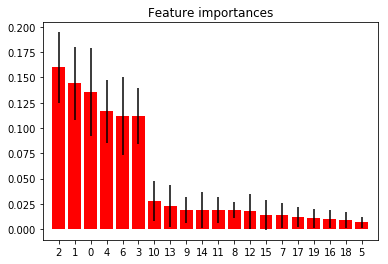

In [18]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [19]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.972396925227114

In [20]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9732655979365739

In [21]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento_aux'
precision_recall

,precision,recall,f1_score
momento_aux,,,
Cena,0.696721,1.000000,0.821256
Ducha,1.000000,0.994536,0.997260
Lavadora,1.000000,0.995074,0.997531
Aspiradora,0.983333,0.941489,0.961957
Afeitadora,1.000000,0.973451,0.986547
Secador_pelo,1.000000,0.964286,0.981818
Aire_acondicionado,1.000000,0.970930,0.985251
Telefono,0.995475,0.995475,0.995475
Tecleo,1.000000,0.886364,0.939759


Confusion matrix, without normalization
[[170   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 182   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0 202   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 10   0   0 177   0   0   0   0   0   0   0   0   0   0   1   0]
 [  3   0   0   0 110   0   0   0   0   0   0   0   0   0   0   0]
 [  6   0   0   0   0 162   0   0   0   0   0   0   0   0   0   0]
 [  5   0   0   0   0   0 167   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0 220   0   0   0   0   0   0   0   0]
 [ 22   0   0   3   0   0   0   0 195   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0 168   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0   0   0   0 177   0   0   0   0   0]
 [  4   0   0   0   0   0   0   1   0   0   0 194   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0 181   0   0   0]
 [  5   0   0   0   0   0   0   0   0   0   0   0   0 194   0   0]
 [  3   0   0   0   0 

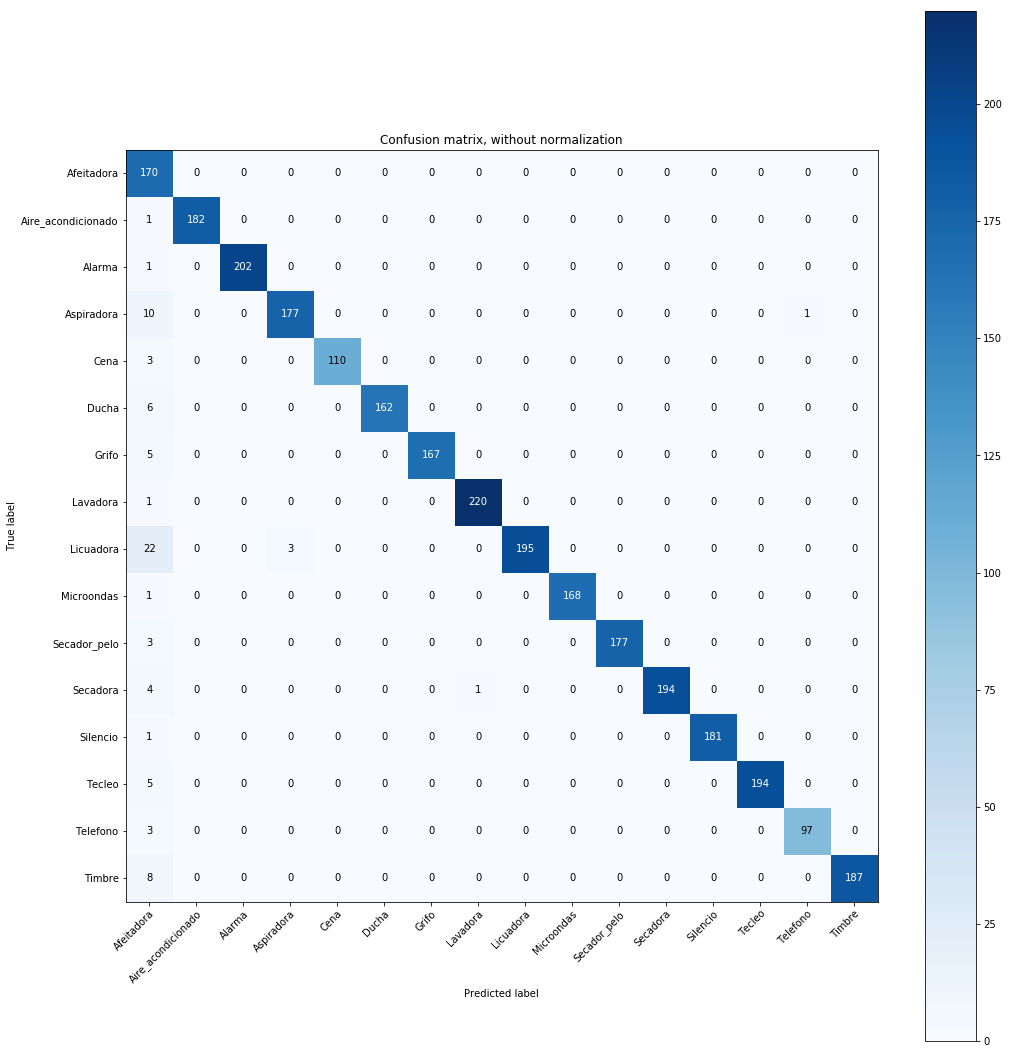

In [22]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [23]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [25]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [26]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [27]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [29]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [30]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

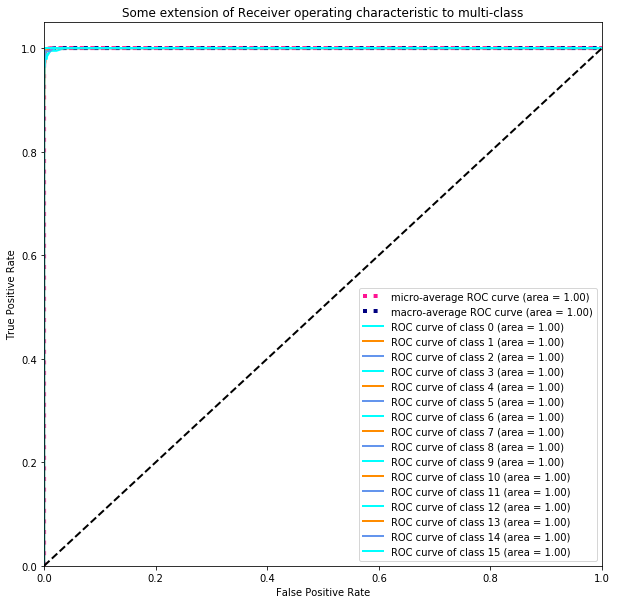

In [31]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# PCA - 10

In [33]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

from itertools import cycle

import seaborn as sns

In [34]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    return theDataFrame

data = readCsvToDataFrame('data_fourier.csv')

In [35]:
features = ['mfcc', 'scem','scom', 'srom','sbwm', 'tempo', 'rmse', 
            'Fourier1', 'Fourier2', 'Fourier3', 'Fourier4', 'Fourier5', 
            'Fourier6', 'Fourier7', 'Fourier8', 'Fourier9', 'Fourier10',
            'Fourier11', 'Fourier12', 'Fourier13', 'Fourier14', 'Fourier15',
            'Fourier16', 'Fourier17', 'Fourier18', 'Fourier19', 'Fourier20',
            'Fourier21', 'Fourier22', 'Fourier23', 'Fourier24', 'Fourier25',
            'Fourier26', 'Fourier27', 'Fourier28', 'Fourier29', 'Fourier30',
            'Fourier31', 'Fourier32']

x = data.loc[:, features].values
y = data.loc[:,['momento']].values

x = StandardScaler().fit_transform(x)

In [36]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1',
                                      'principal component 2',
                                      'principal component 3',
                                      'principal component 4',
                                      'principal component 5',
                                      'principal component 6',
                                      'principal component 7',
                                      'principal component 8',
                                      'principal component 9',
                                      'principal component 10'])

principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,-3.360904,-0.975100,-1.054819,-0.385667,-0.764224,1.670390,0.644908,0.227753,0.942833,-0.075686
1,-1.026358,1.479481,0.077047,0.862667,-0.545208,-0.377048,1.324285,-0.026876,0.100235,1.233359
2,2.956737,-3.923936,1.228273,-0.877412,0.766079,-1.248011,0.139048,-1.652636,-0.563340,-0.658157
3,4.548091,1.769831,-1.323412,0.451506,0.720735,0.861658,-0.965558,0.308555,0.173785,1.220124
4,-0.471525,-2.539757,0.897380,-0.962098,0.426619,-0.069359,-0.489004,0.015258,0.214262,0.032519


In [37]:
principalDf.reset_index(drop=True, inplace=True)

aux = data[['momento']]
aux.reset_index(drop=True, inplace=True)

finalDf = pd.concat([principalDf, aux], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,momento
0,-3.360904,-0.975100,-1.054819,-0.385667,-0.764224,1.670390,0.644908,0.227753,0.942833,-0.075686,Timbre
1,-1.026358,1.479481,0.077047,0.862667,-0.545208,-0.377048,1.324285,-0.026876,0.100235,1.233359,Cena
2,2.956737,-3.923936,1.228273,-0.877412,0.766079,-1.248011,0.139048,-1.652636,-0.563340,-0.658157,Lavadora
3,4.548091,1.769831,-1.323412,0.451506,0.720735,0.861658,-0.965558,0.308555,0.173785,1.220124,Secador_pelo
4,-0.471525,-2.539757,0.897380,-0.962098,0.426619,-0.069359,-0.489004,0.015258,0.214262,0.032519,Aire_acondicionado


In [38]:
print('La variación explicada por cada feature ha sido de {} respectivamente.'.format(pca.explained_variance_ratio_))
print('La variación explicada total de este modelo con respecto al original ha sido del {:.2f}%.'.format(np.sum(pca.explained_variance_ratio_)*100))
print('La variación perdida con respecto al modelo original ha sido del {:.2f}%.'.format(100 - np.sum(pca.explained_variance_ratio_)*100))

La variación explicada por cada feature ha sido de [0.42508945 0.13246001 0.06637617 0.04350658 0.04267792 0.03105384
 0.02702819 0.02502389 0.02341279 0.02142978] respectivamente.
La variación explicada total de este modelo con respecto al original ha sido del 83.81%.
La variación perdida con respecto al modelo original ha sido del 16.19%.


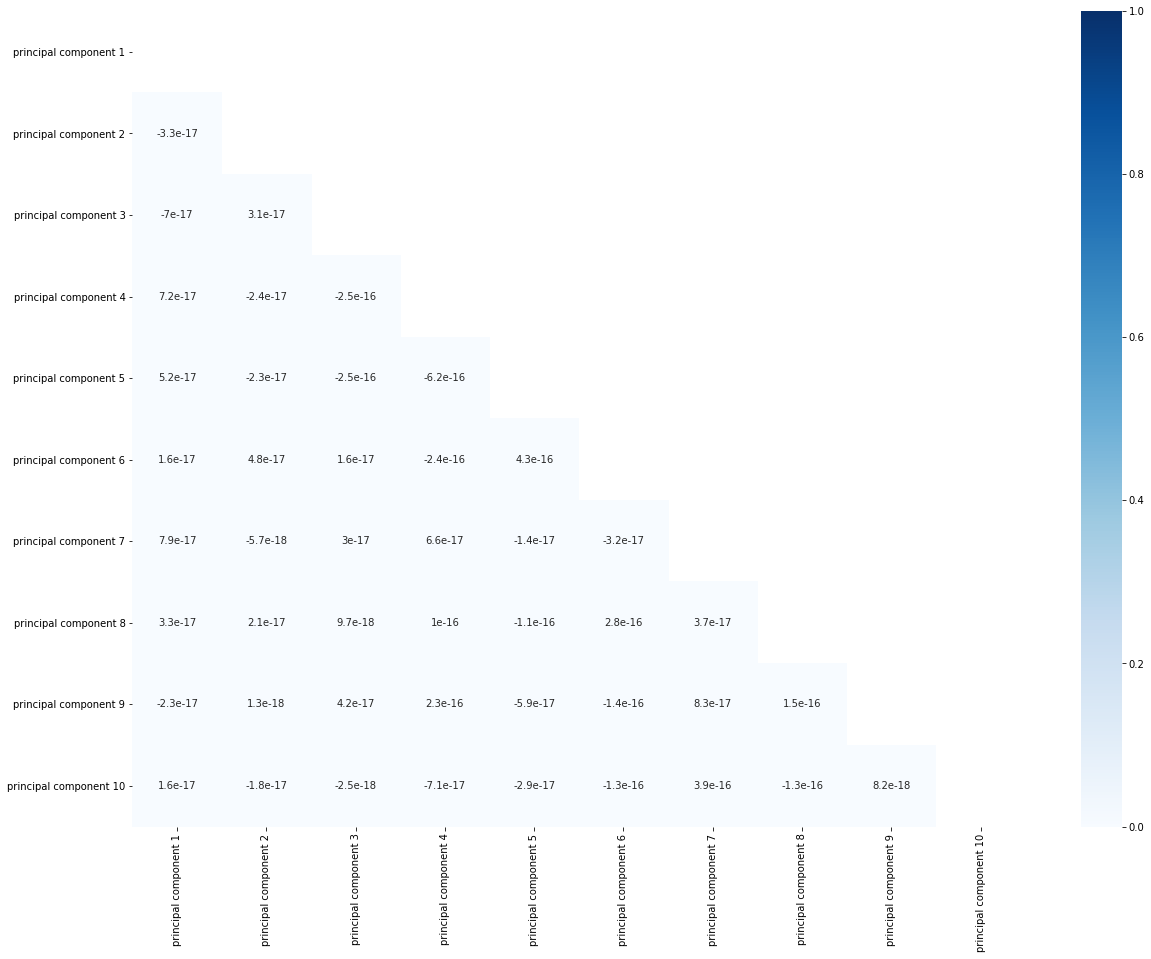

In [39]:
def get_matrix(dataset, classes):
    mask = np.zeros_like(dataset.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20,15))
    ax = sns.heatmap(dataset.corr(), mask=mask, annot=True, cmap="Blues")

#     sns.set(style="ticks")
#     sns.pairplot(dataset, hue=classes)
    
get_matrix(finalDf, 'momento')

In [41]:
y = pd.get_dummies(data=finalDf.momento)
X = data.loc[:, finalDf.columns != 'momento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [42]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=60))
# scores = cross_val_score(clf, X, y, cv=20)
# print(scores)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [43]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9842767295597484

In [44]:
predictions = clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.0
Aire_acondicionado    0.0
Alarma                0.0
Aspiradora            0.0
Cena                  0.0
Ducha                 0.0
Grifo                 0.0
Lavadora              0.0
Licuadora             0.0
Microondas            0.0
Secador_pelo          0.0
Secadora              0.0
Silencio              0.0
Tecleo                0.0
Telefono              0.0
Timbre                0.0
dtype: float64 degrees.


In [45]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)
cls.fit(X_train, y_train)
importances = cls.feature_importances_

In [46]:
std = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)

In [47]:
indices = np.argsort(importances)[::-1]

In [48]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

display(pd.DataFrame(cls.feature_importances_, 
                     index = X_train.columns, 
                     columns = ['importance']).sort_values('importance', ascending=False))

Feature ranking:
1. feature 2 (0.194708)
2. feature 1 (0.168161)
3. feature 0 (0.162221)
4. feature 4 (0.145008)
5. feature 6 (0.134052)
6. feature 3 (0.125259)
7. feature 9 (0.030105)
8. feature 8 (0.023884)
9. feature 5 (0.010274)
10. feature 7 (0.006328)


,importance
scom,0.194708
scem,0.168161
mfcc,0.162221
sbwm,0.145008
rmse,0.134052
srom,0.125259
Fourier3,0.030105
Fourier2,0.023884
tempo,0.010274
Fourier1,0.006328


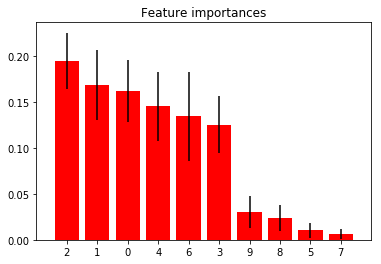

In [49]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [50]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9849755415793152

In [51]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9854039363521667

In [52]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento_aux'
precision_recall

,precision,recall,f1_score
momento_aux,,,
Cena,0.810680,1.000000,0.895442
Ducha,1.000000,1.000000,1.000000
Lavadora,1.000000,0.988571,0.994253
Aspiradora,1.000000,0.958549,0.978836
Afeitadora,0.983740,1.000000,0.991803
Secador_pelo,1.000000,0.978022,0.988889
Aire_acondicionado,1.000000,0.989848,0.994898
Telefono,0.995935,0.995935,0.995935
Tecleo,1.000000,0.937500,0.967742


Confusion matrix, without normalization
[[167   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 194   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0 173   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  8   0   0 185   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 121   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0   1 178   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0 195   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0 245   0   0   0   0   0   0   0   0]
 [ 11   0   0   0   0   0   0   0 180   1   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0 165   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 189   0   0   0   0   0]
 [  3   0   0   0   0   0   0   1   0   0   0 191   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 181   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   0 186   0   0]
 [  1   0   0   0   0 

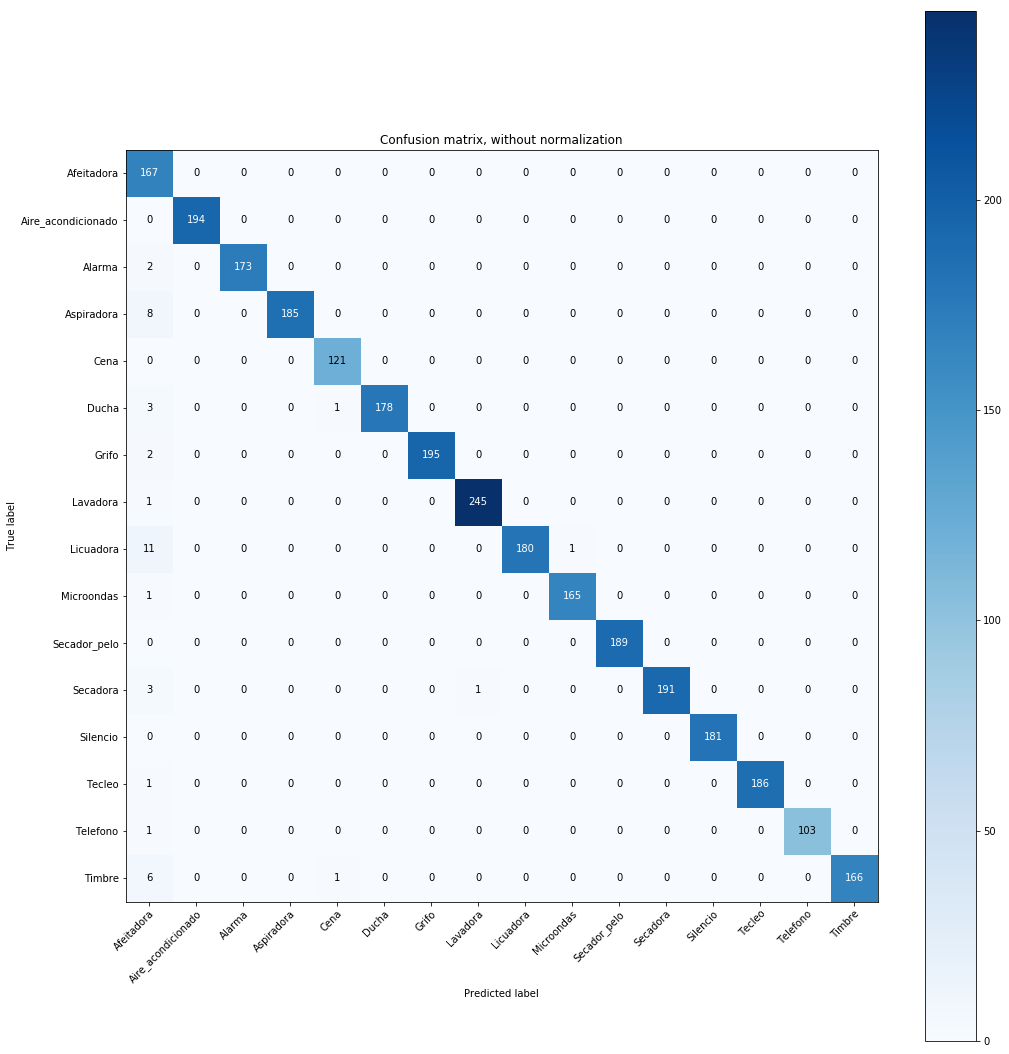

In [53]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [54]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [56]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [57]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [58]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [59]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [60]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [61]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

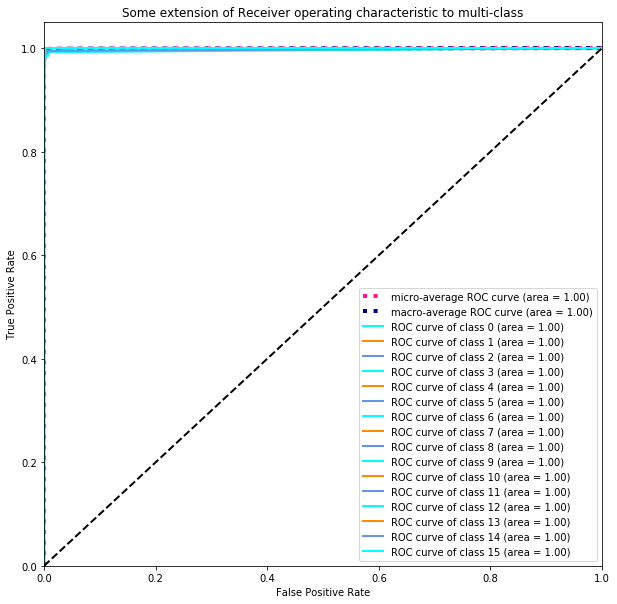

In [62]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# PCA - 8

In [63]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

from itertools import cycle

import seaborn as sns

In [64]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    return theDataFrame

data = readCsvToDataFrame('data_fourier.csv')

In [66]:
features = ['mfcc', 'scem','scom', 'srom','sbwm', 'tempo', 'rmse', 
            'Fourier1', 'Fourier2', 'Fourier3', 'Fourier4', 'Fourier5', 
            'Fourier6', 'Fourier7', 'Fourier8', 'Fourier9', 'Fourier10',
            'Fourier11', 'Fourier12', 'Fourier13', 'Fourier14', 'Fourier15',
            'Fourier16', 'Fourier17', 'Fourier18', 'Fourier19', 'Fourier20',
            'Fourier21', 'Fourier22', 'Fourier23', 'Fourier24', 'Fourier25',
            'Fourier26', 'Fourier27', 'Fourier28', 'Fourier29', 'Fourier30',
            'Fourier31', 'Fourier32']

x = data.loc[:, features].values
y = data.loc[:,['momento']].values

x = StandardScaler().fit_transform(x)

In [97]:
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1',
                                      'principal component 2',
                                      'principal component 3',
                                      'principal component 4',
                                      'principal component 5',
                                      'principal component 6',
                                      'principal component 7',
                                      'principal component 8'])

principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8
0,-3.360904,-0.975092,-1.054797,-0.386525,-0.763803,1.669478,0.654955,0.230591
1,-1.026358,1.479491,0.076942,0.861170,-0.544608,-0.371208,1.327627,-0.014120
2,2.956737,-3.923988,1.228131,-0.872628,0.764369,-1.243447,0.082053,-1.663988
3,4.548091,1.769785,-1.323619,0.456312,0.718003,0.862207,-1.009883,0.289590
4,-0.471525,-2.539757,0.897370,-0.962176,0.427018,-0.069992,-0.486578,0.015922


In [98]:
principalDf.reset_index(drop=True, inplace=True)

aux = data[['momento']]
aux.reset_index(drop=True, inplace=True)

finalDf = pd.concat([principalDf, aux], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,momento
0,-3.360904,-0.975092,-1.054797,-0.386525,-0.763803,1.669478,0.654955,0.230591,Timbre
1,-1.026358,1.479491,0.076942,0.861170,-0.544608,-0.371208,1.327627,-0.014120,Cena
2,2.956737,-3.923988,1.228131,-0.872628,0.764369,-1.243447,0.082053,-1.663988,Lavadora
3,4.548091,1.769785,-1.323619,0.456312,0.718003,0.862207,-1.009883,0.289590,Secador_pelo
4,-0.471525,-2.539757,0.897370,-0.962176,0.427018,-0.069992,-0.486578,0.015922,Aire_acondicionado


In [99]:
print('La variación explicada por cada feature ha sido de {} respectivamente.'.format(pca.explained_variance_ratio_))
print('La variación explicada total de este modelo con respecto al original ha sido del {:.2f}%.'.format(np.sum(pca.explained_variance_ratio_)*100))
print('La variación perdida con respecto al modelo original ha sido del {:.2f}%.'.format(100 - np.sum(pca.explained_variance_ratio_)*100))

La variación explicada por cada feature ha sido de [0.42508945 0.13246001 0.06637617 0.0435064  0.04267786 0.03105363
 0.0270149  0.02502067] respectivamente.
La variación explicada total de este modelo con respecto al original ha sido del 79.32%.
La variación perdida con respecto al modelo original ha sido del 20.68%.


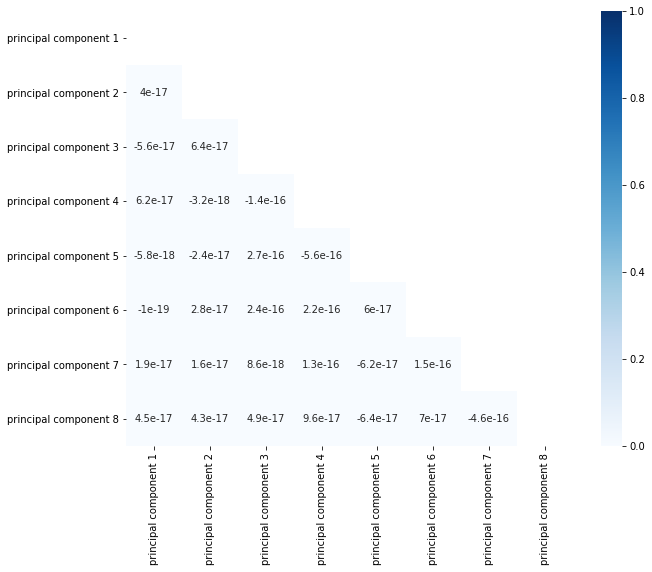

In [100]:
def get_matrix(dataset, classes):
    mask = np.zeros_like(dataset.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(dataset.corr(), mask=mask, annot=True, cmap="Blues")

#     sns.set(style="ticks")
#     sns.pairplot(dataset, hue=classes)
    
get_matrix(finalDf, 'momento')

In [101]:
y = pd.get_dummies(data=finalDf.momento)
X = data.loc[:, finalDf.columns != 'momento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [102]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=60))
# scores = cross_val_score(clf, X, y, cv=20)
# print(scores)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [103]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9849755415793152

In [104]:
predictions = clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.0
Aire_acondicionado    0.0
Alarma                0.0
Aspiradora            0.0
Cena                  0.0
Ducha                 0.0
Grifo                 0.0
Lavadora              0.0
Licuadora             0.0
Microondas            0.0
Secador_pelo          0.0
Secadora              0.0
Silencio              0.0
Tecleo                0.0
Telefono              0.0
Timbre                0.0
dtype: float64 degrees.


In [105]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)
cls.fit(X_train, y_train)
importances = cls.feature_importances_

In [106]:
std = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)

In [107]:
indices = np.argsort(importances)[::-1]

In [108]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

display(pd.DataFrame(cls.feature_importances_, 
                     index = X_train.columns, 
                     columns = ['importance']).sort_values('importance', ascending=False))

Feature ranking:
1. feature 2 (0.205093)
2. feature 0 (0.173938)
3. feature 1 (0.168569)
4. feature 4 (0.143494)
5. feature 6 (0.141681)
6. feature 3 (0.136872)
7. feature 7 (0.015748)
8. feature 5 (0.014605)


,importance
scom,0.205093
mfcc,0.173938
scem,0.168569
sbwm,0.143494
rmse,0.141681
srom,0.136872
Fourier1,0.015748
tempo,0.014605


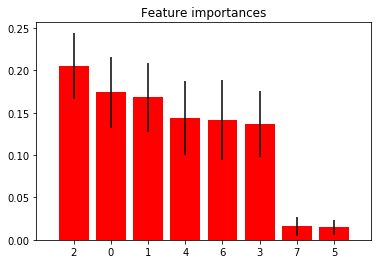

In [109]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [110]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9849755415793152

In [111]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9841041447108504

In [112]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento_aux'
precision_recall

,precision,recall,f1_score
momento_aux,,,
Cena,0.808612,1.000000,0.894180
Ducha,1.000000,1.000000,1.000000
Lavadora,1.000000,0.988889,0.994413
Aspiradora,0.994505,0.957672,0.975741
Afeitadora,1.000000,0.951613,0.975207
Secador_pelo,1.000000,1.000000,1.000000
Aire_acondicionado,1.000000,0.979592,0.989691
Telefono,1.000000,0.991111,0.995536
Tecleo,0.995327,0.950893,0.972603


Confusion matrix, without normalization
[[169   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 173   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0 178   0   0   0   0   0   0   0   0   0   0   0   1   0]
 [  7   0   0 181   0   0   0   0   1   0   0   0   0   0   0   0]
 [  6   0   0   0 118   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 188   0   0   0   0   0   0   0   0   0   0]
 [  4   0   0   0   0   0 192   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0 223   0   0   0   0   0   0   0   0]
 [ 10   0   0   1   0   0   0   0 213   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 186   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0 174   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 174   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 194   0   0   0]
 [  2   0   0   0   0   0   0   0   0   0   0   0   0 168   0   0]
 [  5   0   0   0   0 

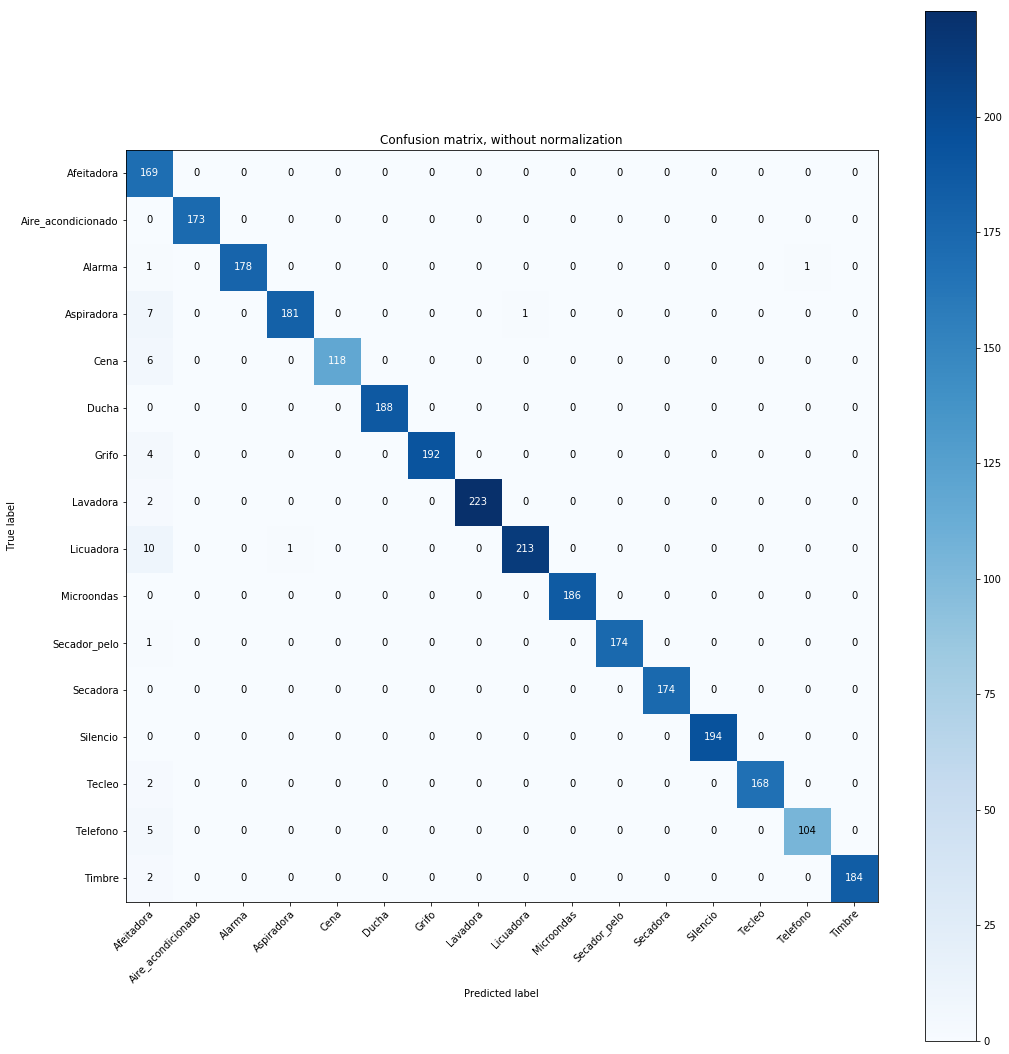

In [113]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [114]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [116]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [117]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [118]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [119]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [120]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [121]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

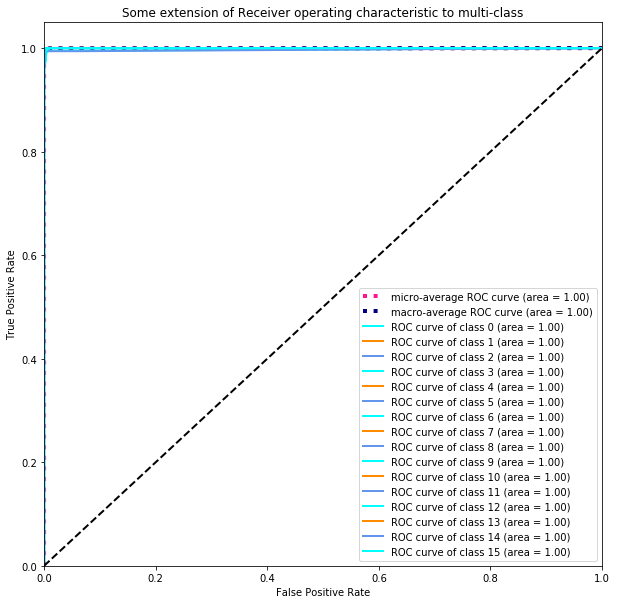

In [122]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Conclusiones

Como se ha podido observar en los diferentes resultados, tras aplicar los diferentes PCA no ha habido una mejora sustancial en la calidad de la regresión, los resultados han pasado de una precisión del 96% al 98% en el mejor de los casos.

Además habría que tener en cuenta la aleatoriedad a la hora de seleccionar el train set y test set. Es por ello, que voy a dejar el modelo final tal y como estaba y no le voy a aplicar ningín PCA.